In [36]:
%pylab inline

import matplotlib.pyplot as plt
import six.moves.cPickle as pickle
import gzip
import os
import sys
import timeit

import numpy as np

import theano
import theano.tensor as T
import matplotlib.pyplot as plt
import csv
import pandas as pd
import six.moves.cPickle as pickle

Populating the interactive namespace from numpy and matplotlib


/Users/jmartine/anaconda/envs/py36/lib/python3.6/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['test', 'f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [37]:
# Load MNIST dataset
dataset='mnist.pkl.gz'
with gzip.open(dataset, 'rb') as f:
        try:
            train_set, valid_set, test_set = pickle.load(f, encoding='latin1')
        except:
            train_set, valid_set, test_set = pickle.load(f)

In [38]:
batch_size = 20  # Size of minibatch
n_train_batches = shape(train_set[0])[0] // batch_size
n_valid_batches = shape(valid_set[0])[0] // batch_size
n_test_batches = shape(test_set[0])[0] // batch_size
print(n_train_batches)

n_hidden =  200  # Number of hidden units

2500


In [39]:
# Declare Theano symbolic variables
x = T.dmatrix("x")
y = T.lvector("y")

In [40]:
# Initialize vector of weights for the hidden layer. The initial values for the weights 
# of a hidden layer i should be uniformly sampled from a symmetric interval that depends 
# on the activation function. For the sigmoid function, it has been shown in Xavier et al.
# (2010) that those limits should be between 4.*sqrt(-6./(n_in+n_hidden)) and 
# 4*sqrt(6./(n_in+n_hidden)

w_h = theano.shared(np.asarray(np.random.uniform(low = -1.0 * np.sqrt(6. / (len(train_set[0][0]) + n_hidden)),
                                    high = 1.0 * np.sqrt(6. / (len(train_set[0][0]) + n_hidden)),
                                    size= (len(train_set[0][0]), n_hidden))),name='w_h',borrow=True)

In [41]:
# initialize the bias term for hidden layer
b_h = theano.shared(value=numpy.zeros(n_hidden),
            name='b_h',borrow=True)

In [42]:
# initialize the weight vector w randomly
#
# this and the following bias variable b
# are shared so they keep their values
# between training iterations (updates)
w = theano.shared(np.asarray(np.random.randn(n_hidden, len(np.unique(train_set[1])))),
                name='w',borrow=True)

In [43]:
# initialize the bias term
b = theano.shared(value=numpy.zeros((len(np.unique(train_set[1])),)),
            name='b',borrow=True)

In [44]:
# Construct Theano expression graph for hidden layer
#s = 1 / (1 + T.exp(-T.dot(x, w_h) - b_h))   # Non-linear activation function for the hidden layer (sigmoid)
s = T.tanh(-T.dot(x, w_h) - b_h)   # Non-linear activation function for the hidden layer (tanh)

In [45]:
# Initialize vector of weights for the output layer. Same as for the Logistic regression
# Construct Theano expression graph
lambd = 0.001 # L2 regularization parameter
p_y_given_x = T.nnet.softmax(T.dot(s, w) + b)   # Probability that target belongs to class i
prediction = T.argmax(p_y_given_x, axis=1)      # The prediction of the model (class whose probability is maximal)
loss = -T.mean(T.log(p_y_given_x)[T.arange(y.shape[0]), y])  # Loss function
cost = loss.mean() + lambd * (w ** 2).sum()      # The cost to minimize
#gw = T.grad(cost=cost, wrt=w)
#gb = T.grad(cost=cost, wrt=b)                   # Compute the gradient of the cost
                                                # w.r.t weight vector w and
                                                # bias term b
                                                # (we shall return to this in a
                                                # following section of this tutorial)

In [46]:
from theano import function
# Function to count errors
aa = T.dvector('aa')
bb = T.dvector('bb')
cc = T.mean(T.neq(aa, bb))
f_err = function([aa, bb], cc)

In [47]:
params_h = [w_h,b_h,w,b]
# compute the gradient of cost with respect to theta (sorted in params)
# the resulting gradients will be stored in a list gparams
gparams = [T.grad(cost, param) for param in params_h]

In [48]:
# Compile
eta = 0.1 # Learning rate
train = theano.function(
          inputs=[x,y],
          outputs=[prediction, loss],
          updates=((w_h, w_h - eta * gparams[0]), (b_h, b_h - eta * gparams[1]), 
                   (w, w - eta * gparams[2]), (b, b - eta * gparams[3])),name='train')
validate = theano.function(
          inputs=[x,y],
          outputs=[prediction, loss],name='validate')
test = theano.function(
          inputs=[x,y],
          outputs=[prediction, loss],name='test')
predict = theano.function(inputs=[x], outputs=prediction, name='predict')

In [49]:
n_epochs = 50

In [50]:
# Train
start_time = timeit.default_timer()

error_train = []
error_valid = []
error_test = []
for i in range(n_epochs):
    for index in range(n_train_batches):
        pred, err = train(train_set[0][index * batch_size: (index + 1) * batch_size], \
                          train_set[1][index * batch_size: (index + 1) * batch_size])
        error_train.append(err)
        
        errores = []
        if ((i*n_train_batches+index)%200 == 0):
            for j in range(n_valid_batches):
                pred_val, err_val = validate(valid_set[0][j * batch_size: (j + 1) * batch_size], \
                              valid_set[1][j * batch_size: (j + 1) * batch_size])
                errores.append(err_val)
            this_error = np.mean(errores)
            error_valid.append(this_error)
            
end_time = timeit.default_timer()
print(('The code for file ran for %.2fm' % ((end_time - start_time) / 60.)), file=sys.stderr)

The code for file ran for 2.96m


(0.075, 0.085)

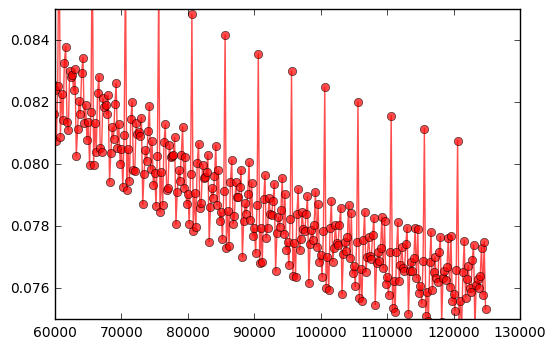

In [67]:
#avg_train_loss = []
#for i in range(int(n_epochs*n_train_batches/100)):
#    avg_train_loss.append(median(error_train[i*100:i*100+100]))


plt.plot(200*arange(len(error_valid)),error_valid,marker='o',color='red',alpha=0.7)
#plt.plot(50+100*arange(len(avg_train_loss)),avg_train_loss,marker='^',color='orange',alpha=0.7)

#plt.yscale('log')
plt.axis('tight')
plt.xlim(60000,130000)
plt.ylim(0.075,0.085)

In [53]:
print("target values for D:")
print(test_set[1])
print("prediction on D:")
print(predict(test_set[0]))
#c = np.equal(test_set[1],predict(test_set[0]))
#errors = c[c == False]
print('Test error = ',100.*f_err(test_set[1],predict(test_set[0])))

target values for D:
[7 2 1 ..., 4 5 6]
prediction on D:
[7 2 1 ..., 4 5 6]
Test error =  2.25
